# Vibe Matcher — Test & Evaluation
This notebook runs **three vibe queries**, logs metrics (Top-1 similarity and a 'good' flag for score ≥ 0.70), and plots **latency** per query.

## Setup & imports

In [1]:

import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

CATALOG_PATH = "vibe_catalog_with_embeddings.parquet"  
MODEL_NAME = "thenlper/gte-large"  
GOOD_THRESH = 0.70
TOP_K = 3


/Users/hildamicheal/Desktop/VibeMatcher/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_parquet(CATALOG_PATH)


dims = df["vector"].apply(lambda v: len(v))
assert dims.nunique() == 1, "Inconsistent embedding dimensions found."
VECTOR_DIM = dims.iloc[0]

model = SentenceTransformer(MODEL_NAME)

def stack_vectors(series):
    import numpy as np
    return np.vstack([np.array(v, dtype=np.float32) for v in series])

product_matrix = stack_vectors(df["vector"])
product_matrix.shape


(10, 1024)

In [3]:

def cosine_topk(query_text, model, item_matrix, df, top_k=TOP_K):
    q_vec = model.encode([query_text])[0].reshape(1, -1)
    sims = cosine_similarity(q_vec, item_matrix)[0]
    idx = np.argsort(-sims)[:top_k]
    results = df.iloc[idx][["id","name","desc","vibes"]].copy().reset_index(drop=True)
    results["similarity"] = [float(sims[i]) for i in idx]
    best = float(np.max(sims))
    return results, best

def evaluate_queries(queries, model, item_matrix, df, good_thresh=GOOD_THRESH):
    logs = []
    for q in queries:
        start = time.perf_counter()
        results, best = cosine_topk(q, model, item_matrix, df, top_k=TOP_K)
        latency = time.perf_counter() - start
        logs.append({
            "query": q,
            "top1_name": results.iloc[0]["name"],
            "top1_score": best,
            "good": bool(best >= good_thresh),
            "latency_s": latency
        })
    return pd.DataFrame(logs)


## Run 3 test queries

In [4]:

queries = [
    "Urban Pulse",
    "Candle Night Dinner" ,
    "Cozy Winter"
]

eval_df = evaluate_queries(queries, model, product_matrix, df, good_thresh=GOOD_THRESH)
eval_df


,query,top1_name,top1_score,good,latency_s
0,Urban Pulse,Denim Revival Jacket,0.784089,True,0.291198
1,Candle Night Dinner,Silk Slip Moonlight,0.775641,True,0.059990
2,Cozy Winter,Puffer Cloud Parka,0.851182,True,0.039150


In [5]:


eval_df.to_csv("eval_log.csv", index=False)


good_rate = (eval_df["good"].sum() / len(eval_df)).__round__(2)
print(f"Good-rate (top1 score ≥ {GOOD_THRESH}): {good_rate*100:.0f}%")
print("Saved detailed log to eval_log.csv")
eval_df


Good-rate (top1 score ≥ 0.7): 100%
Saved detailed log to eval_log.csv


,query,top1_name,top1_score,good,latency_s
0,Urban Pulse,Denim Revival Jacket,0.784089,True,0.291198
1,Candle Night Dinner,Silk Slip Moonlight,0.775641,True,0.059990
2,Cozy Winter,Puffer Cloud Parka,0.851182,True,0.039150


## Plot latency per query

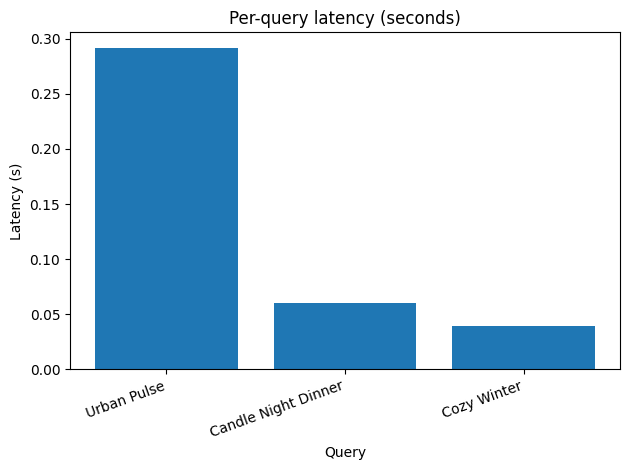

In [6]:

# As required: use matplotlib, a single plot, and do not set specific colors/styles.
plt.figure()
plt.bar(eval_df["query"], eval_df["latency_s"])
plt.title("Per-query latency (seconds)")
plt.xlabel("Query")
plt.ylabel("Latency (s)")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


## Improvements

**Vector Database Integration (Pinecone / FAISS):** For large-scale deployment, moving from in-memory cosine search to vector databases would improve retrieval speed and scalability.

**Richer Metadata Fusion:** Combine text embeddings with product categories, colors, and user feedback for hybrid search (semantic + filter-based).

**Use Domain-Tuned Embedding Models:** Consider fashion-specific models like CLIP (OpenAI) or FashionCLIP for text + image embeddings.


### Edge Cases Handled

**Empty Queries:** Returns a clear message instead of errors (“Please describe a vibe…”).

**Low-Confidence Matches:** Warns user when similarity < threshold and suggests refining input.

**Duplicate / Missing Data:** Validations ensure consistent embeddings before vector stacking.

**Abstract or Off-Domain Inputs:** Handled gracefully with fallback rather than false positives.
